# Analysis of haplotype age - infer direction of movement 

## Setup

In [6]:
%run setup.ipynb
%matplotlib inline
import hapclust

In [7]:
ds_pw_haplotype_age = np.load('../data/pairwise_haplotype_age.npz')
pw_t_hat = ds_pw_haplotype_age['t_hat']

In [24]:
pw_t_hat.shape

(1169685,)

In [43]:
pw_t_hat_sq = scipy.spatial.distance.squareform(pw_t_hat)
pw_t_hat_sq.shape

(1530, 1530)

In [8]:
with open('../data/clust_dict.pickle', mode='rb') as f:
    clust_dict = pickle.load(f)

In [21]:
outbreak_labels = sorted(clust_dict)

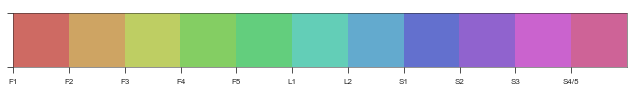

In [22]:
outbreak_colors = sns.color_palette('hls', n_colors=11, desat=0.8)
sns.palplot(outbreak_colors)
ax = plt.gca()
ax.set_xticklabels(outbreak_labels);

In [23]:
lkp_outbreak_color = {l: c for l, c in zip(outbreak_labels, outbreak_colors)}

## Overall age distribution

In [31]:
sns.set_style('white')
sns.set_style('ticks')

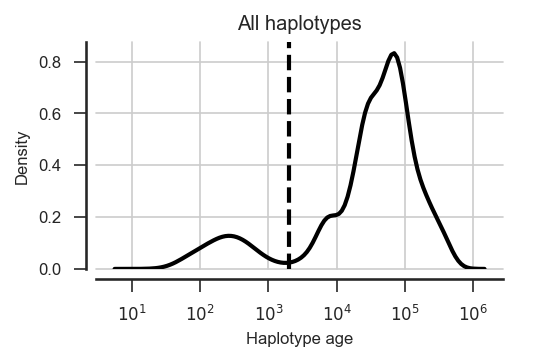

In [59]:
def plot_age_dist_all(ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=150)
        sns.despine(ax=ax, offset=5)
    
    x = np.log10(pw_t_hat)
    md = np.median(x)
    sns.distplot(x, label='All', hist=False, kde_kws=dict(bw=0.15, color='k', linewidth=2), ax=ax)

    ax.axvline(np.log10(2000), color='k', linestyle='--', lw=2)
    ax.set_ylabel('Density')
    xticks = [1, 2, 3, 4, 5, 6]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
    ax.set_xlabel('Haplotype age')
    ax.set_ylim(bottom=0)
    ax.grid(axis='both')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', handles=[])
    ax.set_title('All haplotypes')

#     fn = '../artwork/global_haplogroup_age.svg'
#     fig.savefig(fn, bbox_inches='tight', dpi=150)

#     fn = '../artwork/global_haplogroup_age.png'
#     fig.savefig(fn, bbox_inches='tight', dpi=150)


plot_age_dist_all()

In [41]:
df_haplotypes = phase1_ar31.df_haplotypes
pop_ids = phase1_ar3.pop_ids
pop_labels = phase1_ar3.pop_labels
pop_colors = phase1_ar3.pop_colors

In [42]:
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


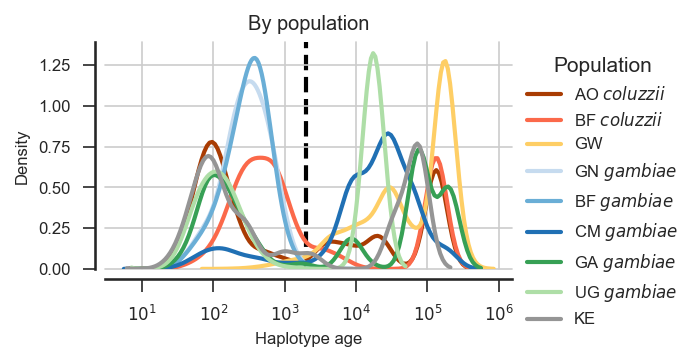

In [71]:
def plot_age_dist_by_pop(ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=150)
        sns.despine(ax=ax, offset=5)
    
    for pop in pop_ids:
        
        hap_idxs = df_haplotypes[df_haplotypes.population == pop].index.values
        pair_idxs = allel.condensed_coords_within(hap_idxs, pw_t_hat_sq.shape[0])
        x = np.log10(pw_t_hat[pair_idxs])
        color = pop_colors[pop]
        lbl = pop_labels[pop]
    
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, 
                     kde_kws=dict(linewidth=2, color=color, bw=0.15))

    ax.axvline(np.log10(2000), color='k', linestyle='--', lw=2, zorder=-20)
    ax.set_ylabel('Density')
    xticks = [1, 2, 3, 4, 5, 6]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
    ax.set_xlabel('Haplotype age')
    ax.set_ylim(bottom=0)
    ax.grid(axis='both')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Population')
    ax.set_title('By population')

#     fn = '../artwork/global_haplogroup_age.svg'
#     fig.savefig(fn, bbox_inches='tight', dpi=150)

#     fn = '../artwork/global_haplogroup_age.png'
#     fig.savefig(fn, bbox_inches='tight', dpi=150)


plot_age_dist_by_pop()

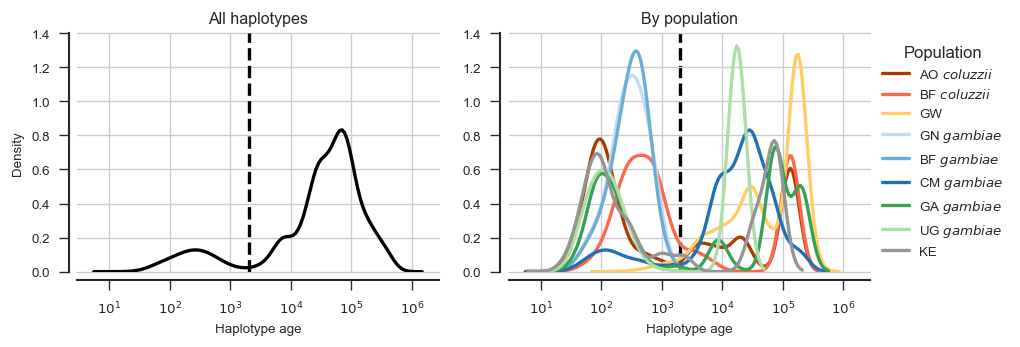

In [75]:
def fig_age_dist(ylim=(0, 1.4)):
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7.5, 3), dpi=120)
    
    ax = axs[0]
    sns.despine(ax=ax, offset=5)
    plot_age_dist_all(ax=ax)
    ax.set_ylim(*ylim)
    
    ax = axs[1]
    sns.despine(ax=ax, offset=5)
    plot_age_dist_by_pop(ax=ax)
    ax.set_ylabel('')
    ax.set_ylim(*ylim)
    
    fig.tight_layout()
    fig.savefig('../artwork/haplotype_age_dist.png', dpi=150, bbox_inches='tight')

fig_age_dist()

## Age distributions within outbreaks

In [79]:
#bootstrap the mean t_hat
def bootstrap(x, n, f):
    dtype = np.array(f(x)).dtype
    out = np.zeros(n, dtype=dtype)
    for i in range(n):
        ix = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        out[i] = f(x[ix])
    return out

In [136]:
df_haplotypes.iloc[[1, 2, 4]]

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [225]:
def plot_age_dist_by_outbreak(outbreak, ax=None, ylab=True, yticks=True, xlab=True, xticks=True, legend=True, bw=.15):

    # obtain indices for haplotypes within the outbreak
    outbreak_hap_ixs = sorted(clust_dict[outbreak])
    
    # subset other data to outbreak
    df_haps_outbreak = df_haplotypes.iloc[outbreak_hap_ixs]
    
    # group by population
    pops_outbreak = df_haps_outbreak.population
    pops_unique = pops_outbreak.unique()
    hap_ixs_pops = [np.array(outbreak_hap_ixs)[(pops_outbreak == p).values] for p in pops_unique]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(4, 3), dpi=120)
        sns.despine(ax=ax, offset=5)
    else:
        fig = None
        ax = ax
        
    for hap_ixs, pop in zip(hap_ixs_pops, pops_unique):
        
        pair_ixs = allel.condensed_coords_within(hap_ixs, pw_t_hat_sq.shape[0])
        x = np.log10(pw_t_hat[pair_ixs])
        color = pop_colors[pop]
        md = np.median(x)
        bs = bootstrap(x, 1000, np.median)
#         lbl = '%s (%.0f; 95%% CI [%.0f, %.0f])' % (pop_labels[pop], 10**md, 
#                                                10**np.percentile(bs, 2.5), 
#                                                10**np.percentile(bs, 97.5))
        lbl = pop_labels[pop]
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, 
                     kde_kws=dict(linewidth=2, color=color, label=lbl, bw=bw))
        ax.axvspan(np.percentile(bs, 2.5), np.percentile(bs, 97.5), 
                   color=color, alpha=.3)
        ax.axvline(md, color=color, lw=2, linestyle='--')
            
    xticks = [1, 2, 3, 4]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
    ax.set_xlabel('Haplotype age (generations)')
    ax.set_xlim(1, 4)
    ax.set_title(outbreak)
    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper right')
    ax.set_ylim(0, 2)
    
    if fig:
        fig.tight_layout()


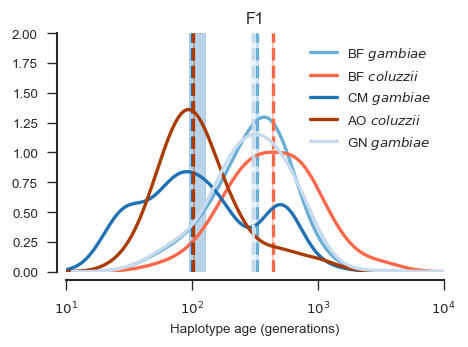

In [226]:
plot_age_dist_by_outbreak('F1')

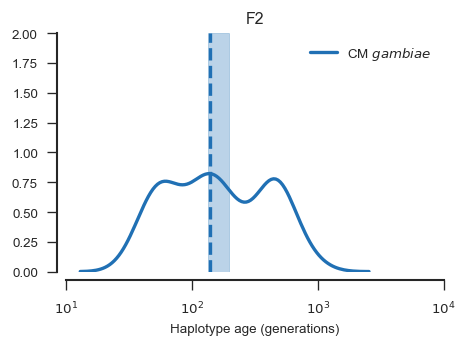

In [227]:
plot_age_dist_by_outbreak('F2')

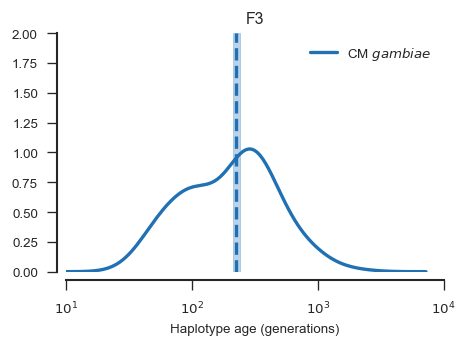

In [228]:
plot_age_dist_by_outbreak('F3')

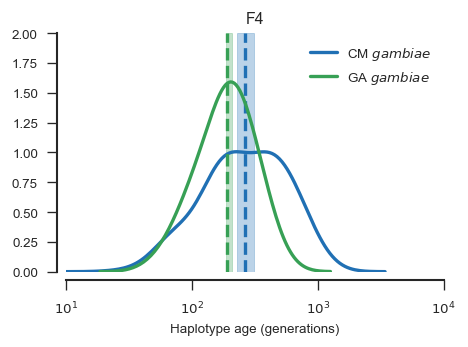

In [229]:
plot_age_dist_by_outbreak('F4')

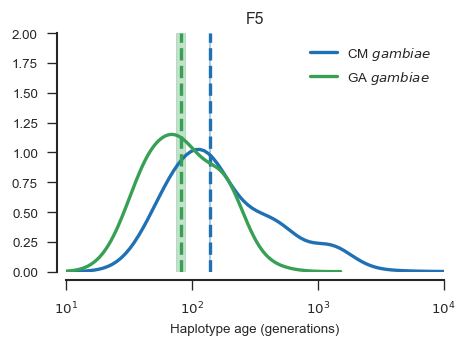

In [230]:
plot_age_dist_by_outbreak('F5')

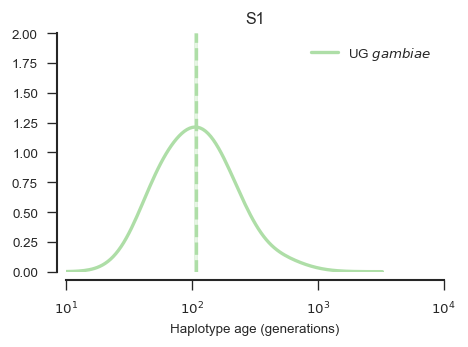

In [231]:
plot_age_dist_by_outbreak('S1')

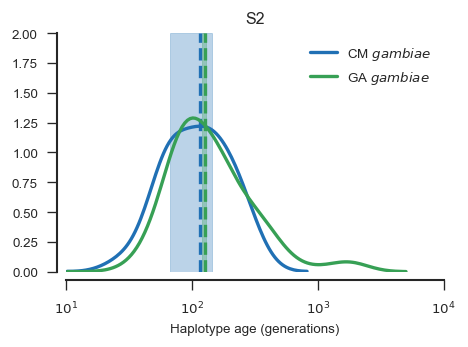

In [232]:
plot_age_dist_by_outbreak('S2')

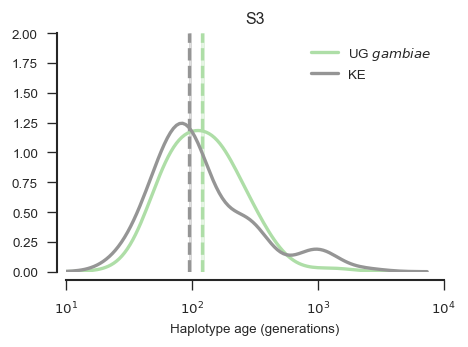

In [233]:
plot_age_dist_by_outbreak('S3')

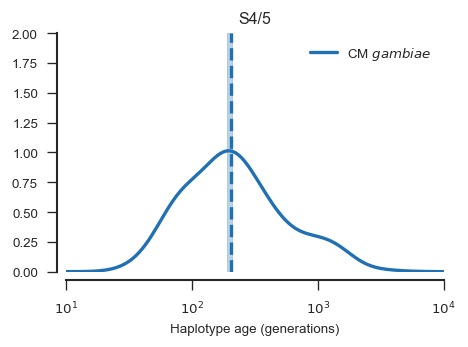

In [234]:
plot_age_dist_by_outbreak('S4/5')

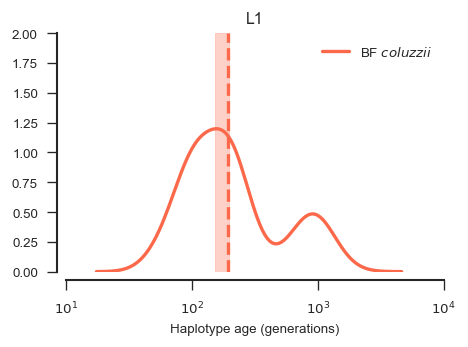

In [235]:
plot_age_dist_by_outbreak('L1')

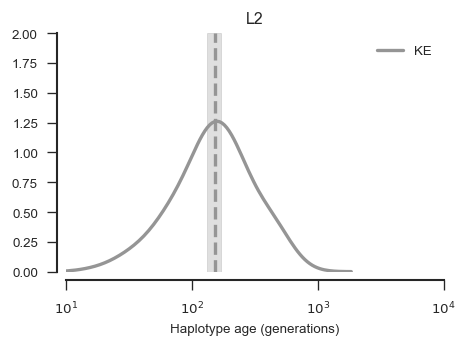

In [236]:
plot_age_dist_by_outbreak('L2')

In [251]:
df_haplotypes.query('population == "CMS" and region == "Mayos"').head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
686,AN0007-Ca,AN0007-C,CMS,"AN0007-Ca [Cameroon, Mayos, S, F]",Cameroon,Mayos,F,S,0.0,0.0
687,AN0007-Cb,AN0007-C,CMS,"AN0007-Cb [Cameroon, Mayos, S, F]",Cameroon,Mayos,F,S,0.0,0.0
688,AN0008-Ca,AN0008-C,CMS,"AN0008-Ca [Cameroon, Mayos, S, F]",Cameroon,Mayos,F,S,0.0,1.0
689,AN0008-Cb,AN0008-C,CMS,"AN0008-Cb [Cameroon, Mayos, S, F]",Cameroon,Mayos,F,S,0.0,1.0
690,AN0009-Ca,AN0009-C,CMS,"AN0009-Ca [Cameroon, Mayos, S, F]",Cameroon,Mayos,F,S,1.0,1.0


In [259]:
def plot_age_dist_by_outbreak_between(outbreak, query1, query2, ax=None, ylab=True, 
                                      yticks=True, xlab=True, xticks=True, legend=True,
                                      bw=.15, color1='k', color2='k'):

    # obtain indices for haplotypes within the outbreak
    outbreak_hap_ixs = sorted(clust_dict[outbreak])
    
    df_haps_pop1 = df_haplotypes.query(query1)
    df_haps_pop2 = df_haplotypes.query(query2)
    hap_ixs_pop1 = [i for i in df_haps_pop1.index.values if i in outbreak_hap_ixs]
    hap_ixs_pop2 = [i for i in df_haps_pop2.index.values if i in outbreak_hap_ixs]
    pops = [query1, query2]
    hap_ixs_pops = [hap_ixs_pop1, hap_ixs_pop2]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(4, 3), dpi=120)
        sns.despine(ax=ax, offset=5)
    else:
        fig = None
        ax = ax
        
    for hap_ixs, pop, color in zip(hap_ixs_pops, pops, [color1, color2]):
        
        pair_ixs = allel.condensed_coords_within(hap_ixs, pw_t_hat_sq.shape[0])
        x = np.log10(pw_t_hat[pair_ixs])
        md = np.median(x)
#         bs = bootstrap(x, 1000, np.median)
        lbl = pop
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, 
                     kde_kws=dict(linewidth=2, color=color, label=lbl, bw=bw))
#         ax.axvspan(np.percentile(bs, 2.5), np.percentile(bs, 97.5), 
#                    color=color, alpha=.3)
#         ax.axvline(md, color=color, lw=2, linestyle='--')
        
    pair_ixs = allel.condensed_coords_between(hap_ixs_pop1, hap_ixs_pop2, pw_t_hat_sq.shape[0])
    x = np.log10(pw_t_hat[pair_ixs])
    color = 'k'
    md = np.median(x)
#     bs = bootstrap(x, 1000, np.median)
    lbl = 'between'
    sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, 
                 kde_kws=dict(linewidth=2, color=color, label=lbl, bw=bw, linestyle='--'))
            
    xticks = [1, 2, 3, 4]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['$10^{%s}$' % t for t in xticks])
    ax.set_xlabel('Haplotype age (generations)')
    ax.set_xlim(1, 4)
    ax.set_title(outbreak)
    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_ylim(0, 2)
    
    if fig:
        fig.tight_layout()


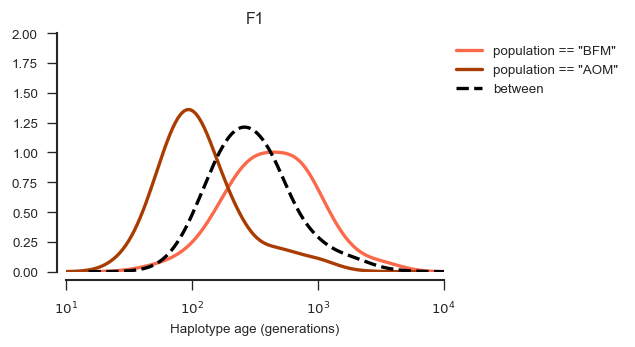

In [260]:
plot_age_dist_by_outbreak_between('F1', 'population == "BFM"', 'population == "AOM"',
                                  color1=pop_colors['BFM'], color2=pop_colors['AOM'])

In [261]:
plot_age_dist_by_outbreak_between('F1', 'BFS', 'GNS')

UndefinedVariableError: name 'BFS' is not defined

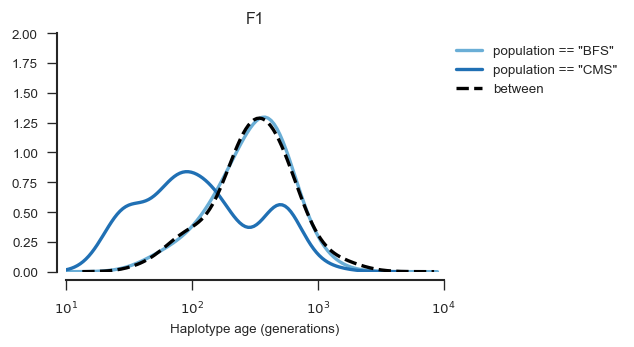

In [265]:
plot_age_dist_by_outbreak_between('F1', 'population == "BFS"', 'population == "CMS"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

In [270]:
df_haplotypes.query('population == "CMS"').region.unique()

array(['Mayos', 'Gado-Badzere', 'Zembe-Borongo', 'Daiguene'], dtype=object)

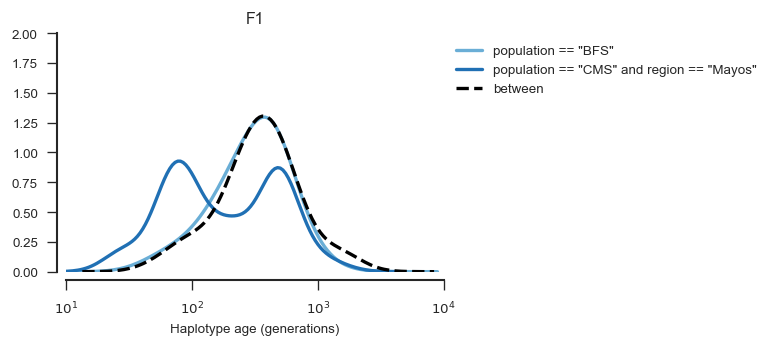

In [275]:
plot_age_dist_by_outbreak_between('F1', 'population == "BFS"', 'population == "CMS" and region == "Mayos"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

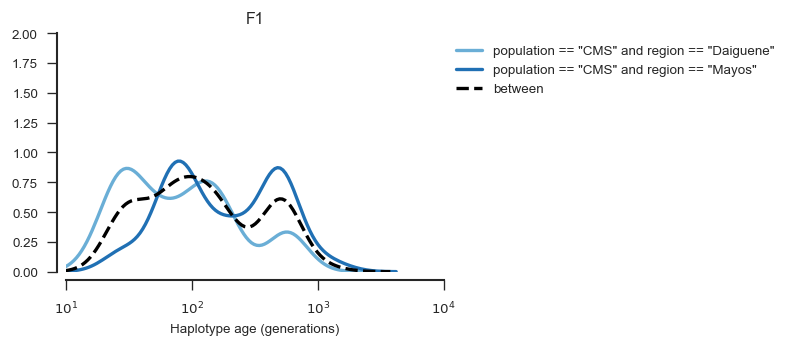

In [276]:
plot_age_dist_by_outbreak_between('F1', 'population == "CMS" and region == "Daiguene"', 'population == "CMS" and region == "Mayos"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

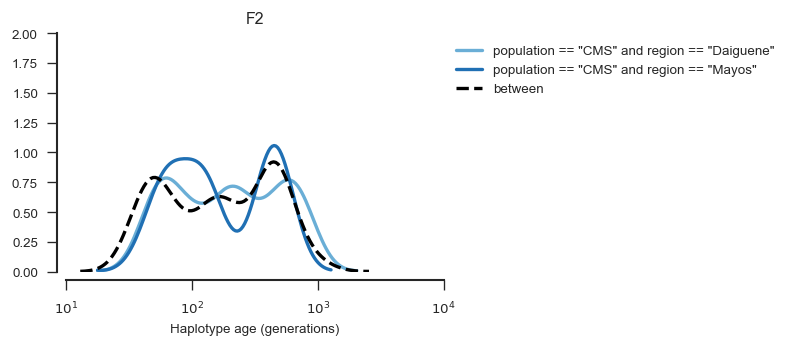

In [280]:
plot_age_dist_by_outbreak_between('F2', 'population == "CMS" and region == "Daiguene"', 'population == "CMS" and region == "Mayos"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

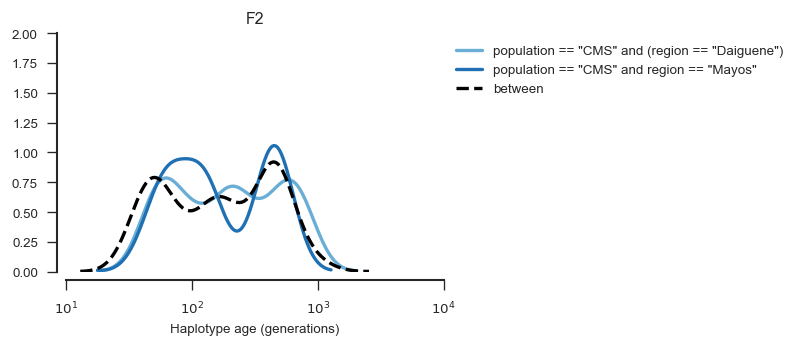

In [286]:
plot_age_dist_by_outbreak_between('F2', 'population == "CMS" and (region == "Daiguene")', 'population == "CMS" and region == "Mayos"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

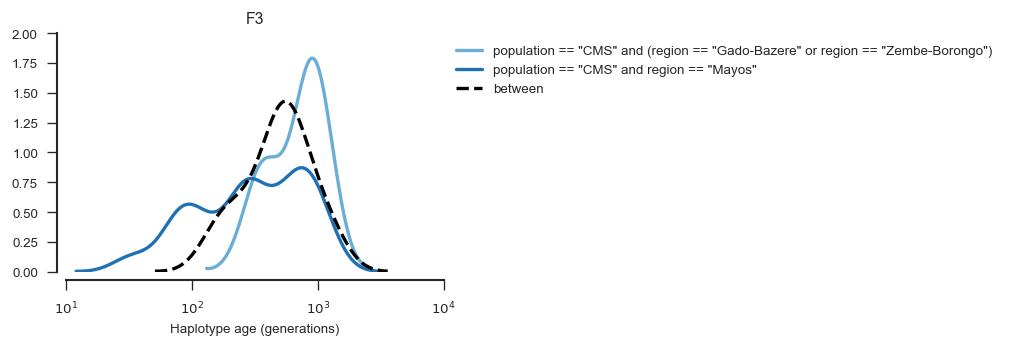

In [282]:
plot_age_dist_by_outbreak_between('F3', 'population == "CMS" and (region == "Gado-Bazere" or region == "Zembe-Borongo")', 'population == "CMS" and region == "Mayos"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

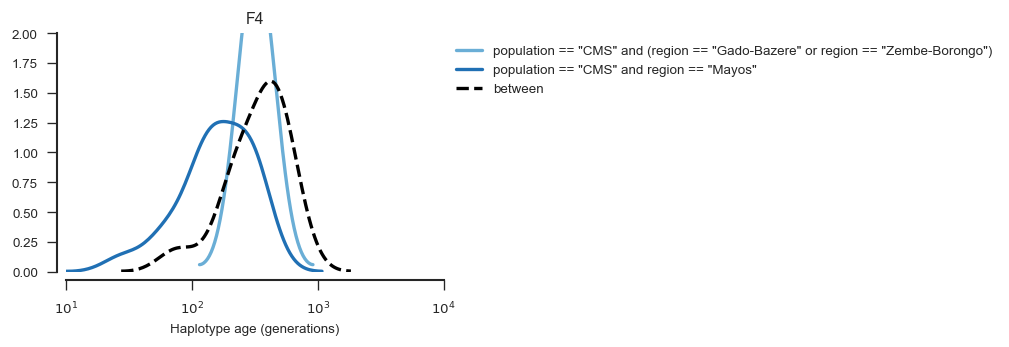

In [287]:
plot_age_dist_by_outbreak_between('F4', 'population == "CMS" and (region == "Gado-Bazere" or region == "Zembe-Borongo")', 'population == "CMS" and region == "Mayos"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

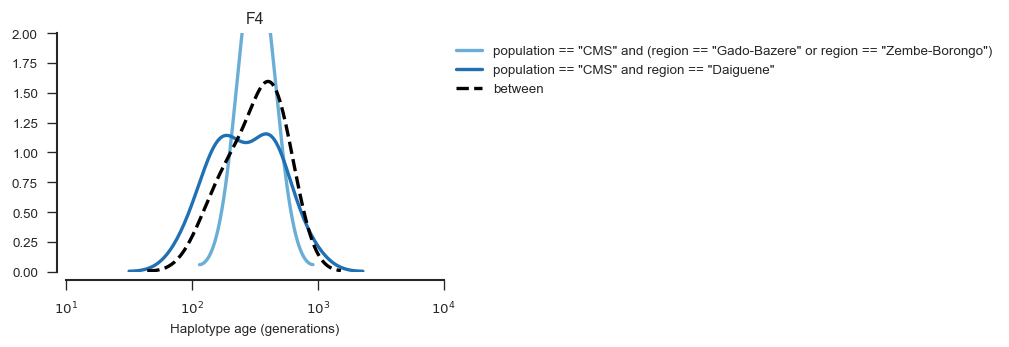

In [288]:
plot_age_dist_by_outbreak_between('F4', 'population == "CMS" and (region == "Gado-Bazere" or region == "Zembe-Borongo")', 'population == "CMS" and region == "Daiguene"', 
                                  bw=.15, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

In [ ]:
plot_age_dist_by_outbreak_between('F1', 'population == "BFS"', 'population == "CMS"', 
                                  bw=.05, color1=pop_colors['BFS'], color2=pop_colors['CMS'])

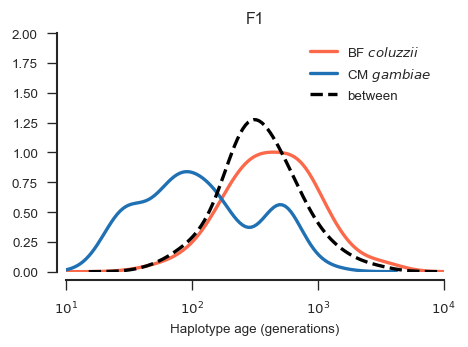

In [247]:
plot_age_dist_by_outbreak_between('F1', 'BFM', 'CMS')

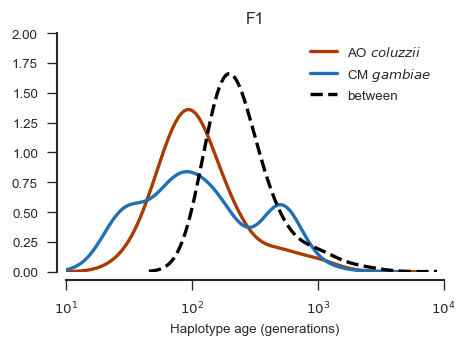

In [240]:
plot_age_dist_by_outbreak_between('F1', 'AOM', 'CMS')

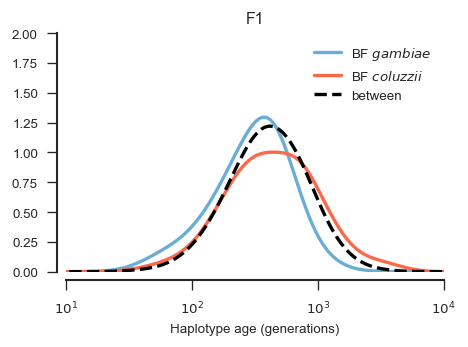

In [241]:
plot_age_dist_by_outbreak_between('F1', 'BFS', 'BFM')

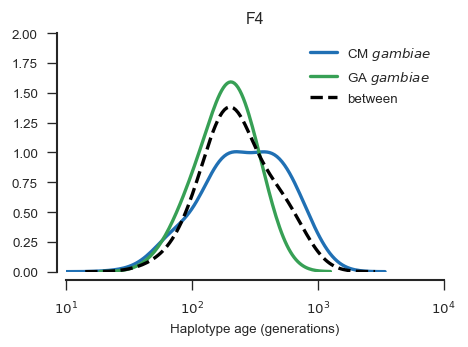

In [242]:
plot_age_dist_by_outbreak_between('F4', 'CMS', 'GAS')

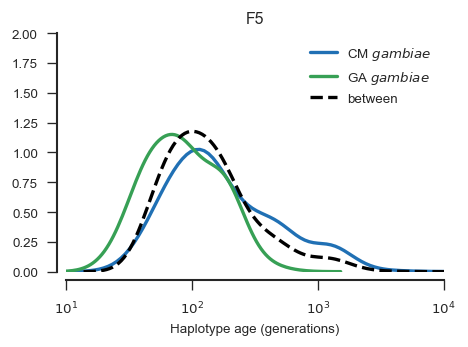

In [243]:
plot_age_dist_by_outbreak_between('F5', 'CMS', 'GAS')

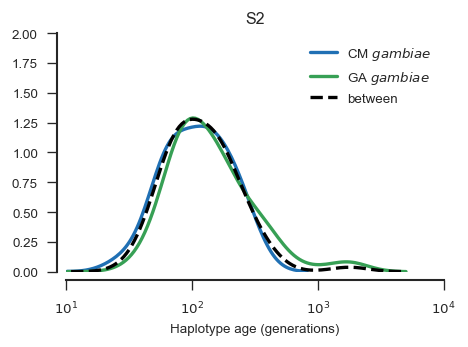

In [244]:
plot_age_dist_by_outbreak_between('S2', 'CMS', 'GAS')

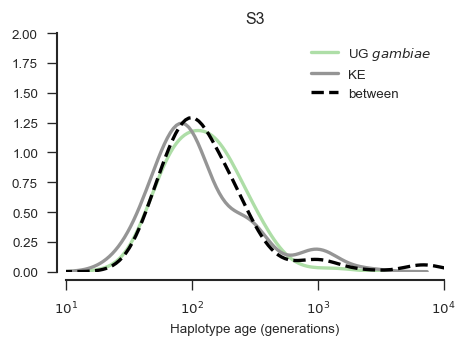

In [245]:
plot_age_dist_by_outbreak_between('S3', 'UGS', 'KES')

## Legacy

In [38]:
# rhg = "resistance haplogroups"
rhg = [f1, f2, f3, f4, f5, s1, s2, s3, s4, l1, l2]
rhg_labels = 'F1 F2 F3 F4 F5 S1 S2 S3 S4/5 L1 L2'.split()

In [39]:
[len(c) for c in rhg]

[461, 13, 51, 42, 197, 108, 79, 162, 73, 16, 18]

In [40]:
for g, l in zip(rhg, rhg_labels):
    print(l)
    print(collections.Counter(df_haplotypes.population[sorted(g)]).most_common())

F1
[('BFS', 162), ('BFM', 113), ('AOM', 91), ('GNS', 62), ('CMS', 33)]
F2
[('CMS', 13)]
F3
[('CMS', 51)]
F4
[('CMS', 26), ('GAS', 16)]
F5
[('CMS', 173), ('GAS', 24)]
S1
[('UGS', 108)]
S2
[('GAS', 71), ('CMS', 8)]
S3
[('UGS', 98), ('KES', 64)]
S4/5
[('CMS', 73)]
L1
[('KES', 16)]
L2
[('BFM', 18)]


In [41]:
pt_hat_both.shape

(1169685,)

## F or S

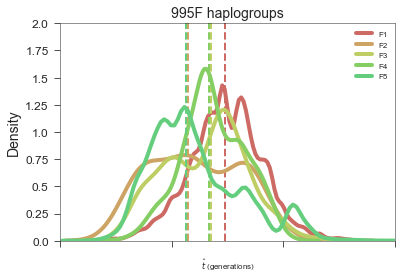

In [42]:
# compare F haplogroups
def compare_F(ax=None, ylab=True, xlab=True, yticks=True, xticks=False):
    if ax==None:
        fig, ax = plt.subplots()
    else:
        ax = ax
    for g, l, cl in zip(rhg[:5], rhg_labels[:5], highlight_colors):
        ixs = allel.condensed_coords_within(g, len(df_haplotypes))
        x = np.log10(pt_hat_both[ixs])
        md = np.median(x)
        #print(l, md)
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
                     kde_kws=dict(linewidth=4, color=cl))
        ax.axvline(md, color=cl, linestyle='--', lw=2)
        
    if xlab == True:
        ax.set_ylabel('Density', fontsize=14)
    ax.set_xlim(1, 4)
    ticks = [1, 2, 3, 4]
    
    ax.set_xticks(ticks)
    
    

    ax.set_title('995F haplogroups', fontsize=14)
    if xticks == True:
        ax.set_xticklabels(['$10^{%s}$' % t for t in ticks])
    else:
        ax.xaxis.set_ticklabels([])
    if ylab == True:
        ax.set_xlabel('$\hat{t}$ (generations)')
        
    ax.set_ylim(0,2)
    if yticks == False:
        ax.yaxis.set_ticklabels([]);

    ax.set_yticklabels(labels=[0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00],fontsize=12)
compare_F()

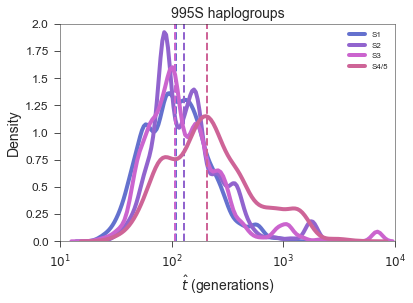

In [43]:
# compare S haplogroups
def compare_S(ax=None, ylab=True, xlab=True, yticks=True):
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax
    for g, l, cl in zip(rhg[5:9], rhg_labels[5:9], highlight_colors[7:]):
        ixs = allel.condensed_coords_within(g, len(df_haplotypes))
        x = np.log10(pt_hat_both[ixs])
        md = np.median(x)
        #print(l, md)
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
                     kde_kws=dict(linewidth=4, color=cl))
        ax.axvline(md, color=cl, linestyle='--', lw=2)
    if xlab == True:
        ax.set_ylabel('Density', fontsize=14)
    
    ax.set_xlim(1, 4)
    ticks = [1, 2, 3, 4]
    ax.set_xticks(ticks)
    ax.set_title('995S haplogroups', fontsize=14)
    ax.set_xticklabels(['$10^{%s}$' % t for t in ticks], fontsize=12)

    if ylab == True:
        ax.set_xlabel('$\hat{t}$ (generations)', fontsize=14)
    ax.set_ylim(0,2)
    if yticks == False:
        ax.yaxis.set_ticklabels([]);
    ax.set_yticklabels(labels=[0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00],fontsize=12)
compare_S()

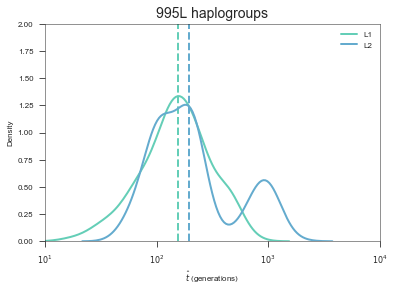

In [44]:
# compare S haplogroups
def compare_L(ax=None, ylab=True, xlab=True, yticks=True):
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax
    for g, l, cl in zip(rhg[9:], rhg_labels[9:], highlight_colors[5:]):
        ixs = allel.condensed_coords_within(g, len(df_haplotypes))
        x = np.log10(pt_hat_both[ixs])
        md = np.median(x)
        #print(l, md)
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
                     kde_kws=dict(linewidth=2, color=cl))
        ax.axvline(np.median(x), color=cl, linestyle='--', lw=2)
    if xlab == True:
        ax.set_ylabel('Density')
    ax.set_xlim(1, 4)
    ticks = [1, 2, 3, 4]
    ax.set_xticks(ticks)
    ax.set_title('995L haplogroups', fontsize=14)
    ax.set_xticklabels(['$10^{%s}$' % t for t in ticks])
    ax.set_ylim(0,2)
    if ylab == True:
        ax.set_xlabel('$\hat{t}$ (generations)')
    if yticks == False:
        ax.yaxis.set_ticklabels([]);
compare_L()

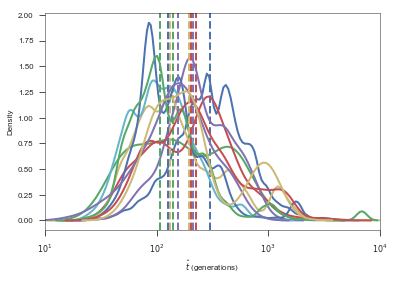

In [45]:
#all?
fig, ax = plt.subplots()



for g, l, cl in zip(rhg, rhg_labels, palette):
    ixs = allel.condensed_coords_within(g, len(df_haplotypes))
    x = np.log10(pt_hat_both[ixs])
    md = np.median(x)
    #print(l, md)
    sns.distplot(x, hist=False, 
                 kde_kws=dict(linewidth=2, color=cl), ax=ax)
    ax.axvline(np.median(x), color=cl, linestyle='--', lw=2)
ax.set_ylabel('Density')
ax.set_xlim(1, 4)
ticks = [1, 2, 3, 4]
ax.set_xticks(ticks)
ax.set_xticklabels(['$10^{%s}$' % t for t in ticks])
ax.set_xlabel('$\hat{t}$ (generations)');

## within haplogroups

In [46]:
#make a dict to update pop labels 
labdic = {
    'CMS': 'CM$Ag$',
    'KES': 'KE',
    'UGS': 'UG$Ag$',
    'GAS': 'GA$Ag$',
    'AOM': 'AO$Ac$',
    'BFS': 'BF$Ag$',
    'BFM': 'BF$Ac$',
    'GNS': 'GN$Ag$',
    'GWA': 'GW'
}

In [47]:
#bootstrap the mean t_hat
def bootstrap(x, n, f):
    dtype = np.array(f(x)).dtype
    out = np.zeros(n, dtype=dtype)
    for i in range(n):
        ix = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        out[i] = f(x[ix])
    return out

In [48]:
def distplot_cluster_pop_t_hat(cluster, title, ax=None, ylab=True, yticks=True, xlab=True, xticks=True):
    cluster = list(cluster)
    pops_clst = df_haplotypes.population[cluster]
    pops_unique = pops_clst.unique()
    pops_subclusters = [np.array(cluster)[(pops_clst == p).values] for p in pops_unique]
    
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax
    for g, l in zip(pops_subclusters, pops_unique):
        ixs = allel.condensed_coords_within(g, len(df_haplotypes))
        x = np.log10(pt_hat_both[ixs])
        color = phase1_ar3.pop_colors[l]
        md = np.median(x)
        bs = bootstrap(x, 1000, np.median)
        lbl = '%s (%.0f; 95%% CI [%.0f, %.0f])' % (labdic[l], 10**md, 
                                               10**np.percentile(bs, 2.5), 
                                               10**np.percentile(bs, 97.5))
        sns.distplot(x, bins=np.linspace(1, 3, 20), label=lbl, hist=False, 
                     kde_kws=dict(linewidth=4, color=color, label=lbl))
        ax.axvspan(np.percentile(bs, 2.5), np.percentile(bs, 97.5), 
                   color=color, alpha=.3)
        ax.axvline(md, color=color, lw=2, linestyle='--')
    
    #ax.set_xlabel('$\hat{t}$')
    if ylab == True:
        ax.set_ylabel(' ')
    ax.set_xlim(1, 4)
    ticks = [1, 2, 3, 4]
    ax.set_xticks(ticks)
    if xticks == True:
        ax.set_xticklabels(['$10^{%s}$' % t for t in ticks], fontsize=12)
    else:
        ax.set_xticklabels([])
    if xlab == True:
        ax.set_xlabel('$\hat{t}$ (generations)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper right', fontsize=10)
    ax.set_ylim(0,2)
    if yticks == False:
        ax.yaxis.set_ticklabels([])
        ##ax.yaxis.set_major_locator(plt.NullLocator());
    #fig.tight_layout()

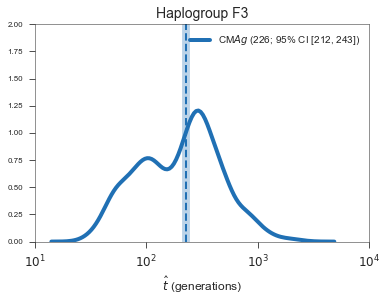

In [49]:
distplot_cluster_pop_t_hat(f3, 'Haplogroup F3')

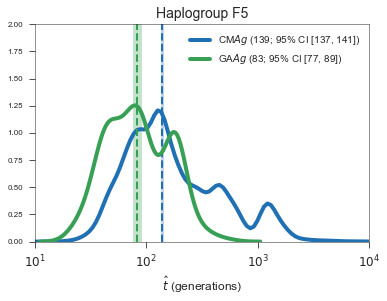

In [50]:
distplot_cluster_pop_t_hat(f5, 'Haplogroup F5')

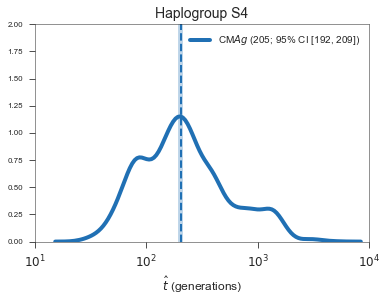

In [51]:
distplot_cluster_pop_t_hat(s4, 'Haplogroup S4')

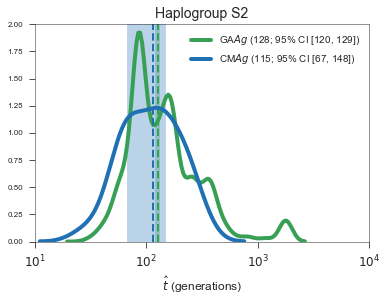

In [52]:
distplot_cluster_pop_t_hat(s2, 'Haplogroup S2')

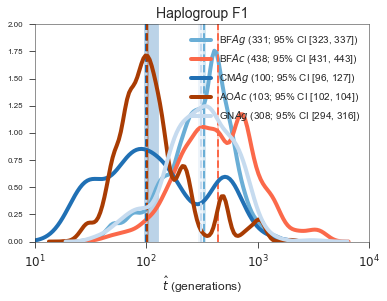

In [53]:
distplot_cluster_pop_t_hat(f1, 'Haplogroup F1')

### create composite figure

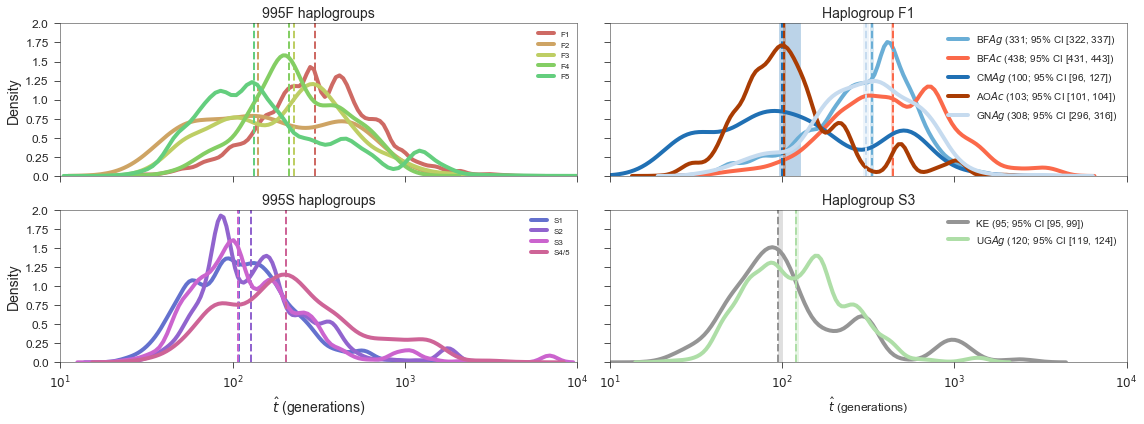

In [54]:
fig = plt.figure(figsize=(16, 6), )
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2)
ax = fig.add_subplot(gs[0,0])
compare_F(ax=ax, ylab=False, xlab=True)
ax = fig.add_subplot(gs[1,0])
compare_S(ax=ax, ylab=True, xlab=True)

ax = fig.add_subplot(gs[0,1])
distplot_cluster_pop_t_hat(f1, 'Haplogroup F1', ax=ax, ylab=True, yticks=False, xlab=False, xticks=False)

ax = fig.add_subplot(gs[1,1])
distplot_cluster_pop_t_hat(s3, 'Haplogroup S3', ax=ax, ylab=True, yticks=False)

gs.tight_layout(fig)
fn = '../artwork/Figure_3_RelativeAges_tweak.hls.jpeg'
fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

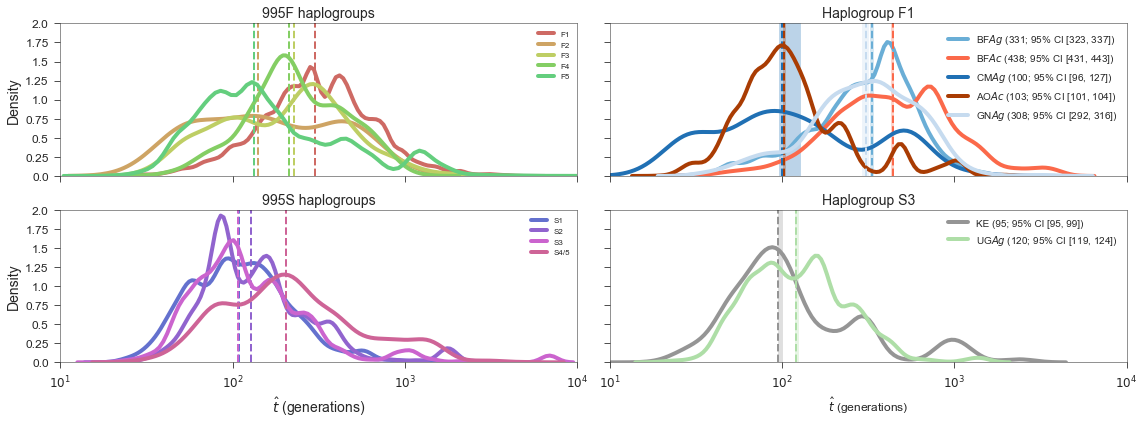

In [55]:
fig = plt.figure(figsize=(16, 6), )
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2)
ax = fig.add_subplot(gs[0,0])
compare_F(ax=ax, ylab=False, xlab=True)
ax = fig.add_subplot(gs[1,0])
compare_S(ax=ax, ylab=True, xlab=True)

ax = fig.add_subplot(gs[0,1])
distplot_cluster_pop_t_hat(f1, 'Haplogroup F1', ax=ax, ylab=True, yticks=False, xlab=False, xticks=False)

ax = fig.add_subplot(gs[1,1])
distplot_cluster_pop_t_hat(s3, 'Haplogroup S3', ax=ax, ylab=True, yticks=False)

gs.tight_layout(fig)
fn = '../artwork/Figure_3_RelativeAges_tweak.hls.pdf'
fig.savefig(fn, bbox_inches='tight')

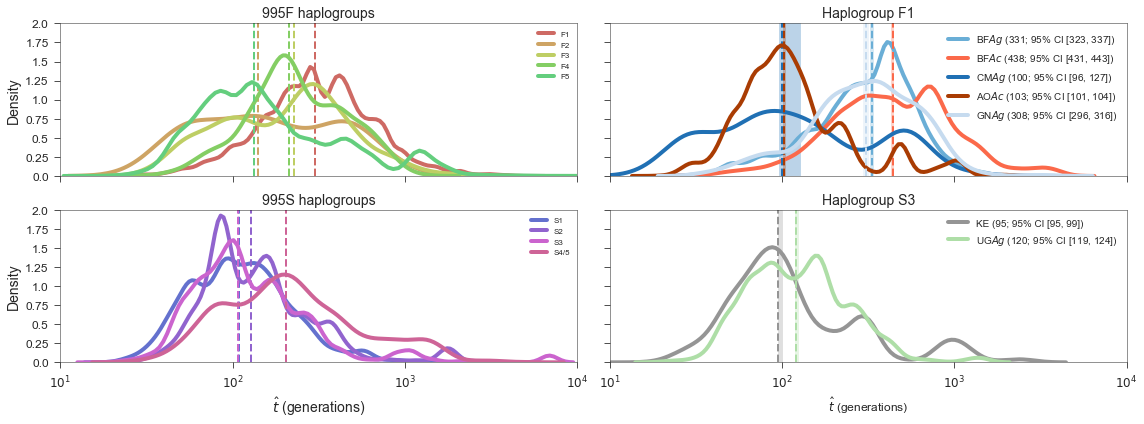

In [56]:
fig = plt.figure(figsize=(16, 6), )
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2)
ax = fig.add_subplot(gs[0,0])
compare_F(ax=ax, ylab=False, xlab=True)
ax = fig.add_subplot(gs[1,0])
compare_S(ax=ax, ylab=True, xlab=True)

ax = fig.add_subplot(gs[0,1])
distplot_cluster_pop_t_hat(f1, 'Haplogroup F1', ax=ax, ylab=True, yticks=False, xlab=False, xticks=False)

ax = fig.add_subplot(gs[1,1])
distplot_cluster_pop_t_hat(s3, 'Haplogroup S3', ax=ax, ylab=True, yticks=False)

gs.tight_layout(fig)
fn = '../artwork/Figure_3_RelativeAges_tweak.hls.svg'
fig.savefig(fn, bbox_inches='tight')

# global haplotype age

In [57]:
#pops_clst - except we want everything here so...
cluster = np.arange(1530)
pops_clst = df_haplotypes.population[cluster]
pops_unique = pops_clst.unique()
pops_subclusters = [np.array(cluster)[(pops_clst == p).values] for p in pops_unique]
all_haps_idx = np.arange(1530)

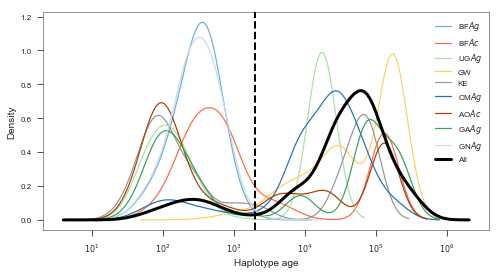

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))
for g, l in zip(pops_subclusters, pops_unique):
    
    ixs = allel.condensed_coords_within(g, len(df_haplotypes))
    x = np.log10(pt_hat_both[ixs])
    color = phase1_ar3.pop_colors[l]
    #md = np.median(x)
    #bs = bootstrap(x, 1000, np.median)
    #lbl = '%s (%.0f; 95%% CI [%.0f, %.0f])' % (labdic[l], 10**md, 
#                                            10**np.percentile(bs, 2.5), 
#                                            10**np.percentile(bs, 97.5))
    sns.distplot(x, bins=np.linspace(1, 3, 20), label=labdic[l], hist=False, 
                 kde_kws=dict(linewidth=1.2, color=color, bw=0.2))
    
x = np.log10(pt_hat_both)
md = np.median(x)
sns.distplot(x, label='All', hist=False, kde_kws=dict(bw=0.2, color='k', linewidth=3), ax=ax)

ax.axvline(np.log10(2000), color='k', linestyle='--', lw=2)
ax.set_ylabel('Density', fontsize=10)
ticks = [1, 2, 3, 4, 5, 6]
ax.set_xticks(ticks)
ax.set_xticklabels(['$10^{%s}$' % t for t in ticks])
ax.set_xlabel('Haplotype age', fontsize=10)

fn = '../artwork/global_haplogroup_age.svg'
fig.savefig(fn, bbox_inches='tight')

fn = '../artwork/global_haplogroup_age.jpeg'
fig.savefig(fn, bbox_inches='tight');

In [59]:
##### NOTES
#We need to look at Ghana and Mali to see if we see the 'correct' age pattern shows in gam/col samples from the same site/collection date i.e. that tmrca is shorter in col than gam – UNLIKE WHAT WE SEE IN BURKINA - see below

##### Between haplogroups